# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


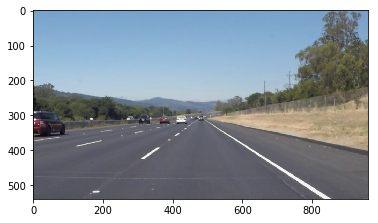

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def load_image(image_file, log=None):
    """
    Load an image.

    Args:
        image_file (str): Image file name

    Returns:
        image: The loaded image object.
    """
    if log:
        log.info('Loading image ''{}'' ...'.format(image_file))
    else:
        print('Loading image ''{}'' ...'.format(image_file))
    image = mpimg.imread(image_file)
    if log:
        log.debug('Image {0}:\ntype: {1}\ndimensions: {2}'.format(
                  image_file, type(image), image.shape))

    return image


def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian Noise kernel

    Args:
        img (image): Blur this image
        kernel_size (int): Use this kernel size for blurring the image.

    Returns:
        image: The blurred image.
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def canny(img, low_threshold, high_threshold):
    """
    Applies the Canny transform

    Args:
        img (image): Transform this image
        low_threshold (int): Canny low threshold
        high_threshold (int): Canny high threshold

        If an edge pixel's gradient value is:
            > high_threshold
                it is marked as a strong edge pixel
            in [low_threshold, high_threshold]
                it is marked as a weak edge pixel
            < low_threshold
                it will be suppressed

        For a grayscale image we have 8 color bits == 2^8 == 256 so the
        thresholds in this case would be in [1, 256]

        Canny recommends a ratio of 1:2 or 1:3 for low-to-high threshold.

    Returns:
        image: The result of applying Canny edge detection.
    """
    return cv2.Canny(img, low_threshold, high_threshold)


def mask_polygon(img, top, delta_top, delta_bottom):
    """
    Given an image, return a list of vertices describing a quadrilateral
    that can be used to mask the image for lane line detection.

    Args:
        img (image): The image to be masked (we need this only for shape).
        top (int): The top of the mask polygon.
        delta_top (int): Half the width of the top of the mask polygon.
        delta_bottom (int): Half the width of the botto of the mask polygon.

    Returns:
        numpy array of vertices: A set of four vertices describing a quadrilateral.
    """
    imshape = img.shape  # 0 == y, 1 == x
    lower_left = (delta_bottom, imshape[0])
    upper_left = (imshape[1] / 2 - delta_top, top)
    upper_right = (imshape[1] / 2 + delta_top, top)
    lower_right = (imshape[1] - delta_bottom, imshape[0])
    vertices = np.array([[lower_left, upper_left, upper_right, lower_right]],
                        dtype=np.int32)
    return vertices


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.

    Args:
        img (image): Mask this image
        vertices (numpy array of integers): A polygon to use for the mask

    Returns:
        image: The masked image.
    """
    # Define a blank mask to start with
    mask = np.zeros_like(img)

    # Defini a 3 channel or 1 channel color to fill the mask with depending
    # on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # Fill pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,
                log=None):
    """
    Apply the Hough transform

    Args:
        img (image): Transform this image - should be output of Canny transform
        rho (int): Distance resolution in pixels of the Hough grid.
        theta (int): Angular resolution in radians of the Hough grid.
        threshold (int): Min. number of votes (intersections in a Hough grid cell)
        min_line_len (int): Min. # of pixels making up a line.
        max_line_gap (int): Max. # of piexls between connectable line segments.

    Returns:
        image: image with Hough lines drawn.
    """
    # Generate Hough lines.
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    # Create a blank image to draw on.
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # Draw lines
    draw_lines(line_img, lines, log=log)
    return line_img


def draw_lines(img, lines, color=[255, 0, 0], thickness=2, log=None):
    """
    NOTE: this is the function you might want to use as a starting point once
    you want to average/extrapolate the line segments you detect to map out
    the full extent of the lane (going from the result shown in raw-lines
    example.mp4 to that shown in P1_example.mp4).

    Think about things like separating line segments by their slope
        dy / dx == ((y2 - y1) / (x2 - x1))
    to decide which segments are part of the left line vs. the right line.
    Then, you can average the position of each of the lines and extrapolate
    to the top and bottom of the lane.

    This function draws 'lines' with 'color' and 'thickness'.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below.

    Args:
        img (image): Draw lines on this image
        lines (array of lines as pairs of integer coords): Draw these lines
        color (RGB array of ints): Draw lines using this color.
        thickness (int): Draw lines using this thickness

    Returns:
        None
    """
    epsilon = 0.9  # Threshold to test for valid slope.

    # Calculate the average slope and center point for each line segment.
    # Then use the slope-intercept line formula to generate end points for
    # a straight line through the average center with the average slope.
    # This will not work at all well for curves but is adequate for relatively
    # straight lane lines.

    # Calculate slope and center for each line segment. Use the slope to
    # separate lines into left and right.
    lm = []
    rm = []
    lc = []
    rc = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2 - y1) / (x2 - x1))  # dy / dx
            c = [(x2 + x1) / 2, (y2 + y1) / 2]
            if log:
                log.debug('slope: {0}'.format(m))
            if -epsilon < m and m < 0.:
                lm.append(m)
                lc.append(c)
            elif 0. < m and m < epsilon:
                rm.append(m)
                rc.append(c)

    # Take the average slope and average center so we have single slope and
    # center values for left and right.
    l_slope = np.average(lm)
    r_slope = np.average(rm)

    l_center = np.average(lc, axis=0)
    r_center = np.average(rc, axis=0)

    if log:
        log.debug('r/l slope={0}/{1}'.format(l_slope, r_slope))
        log.debug('r/l center={0}/{1}'.format(l_center, r_center))

    # Start with the standard slope-intercept line formula:
    # y = mx + b
    # Ignore the y-intercept value (b).
    # (y - y') = m(x - x')
    # (y - y') / m = x - x'
    # x' = x - ((y - y') / m)

    # Use the center and slope calculated above as our (x, y) and m values,
    # respectively.
    # For y' we'll use the bottom of the image for one point and the mid-point
    # of the image for our other point.
    imshape = img.shape  # 0 == y, 1 == x
    y1 = int(imshape[0])
    y2 = int(0.6 * imshape[0])

    if len(lc) > 0:
        x1 = int(l_center[0] - ((l_center[1] - y1) / l_slope))
        x2 = int(l_center[0] - ((l_center[1] - y2) / l_slope))
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    if len(rc) > 0:
        x1 = int(r_center[0] - ((r_center[1] - y1) / r_slope))
        x2 = int(r_center[0] - ((r_center[1] - y2) / r_slope))
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

#    for line in lines:
#        for x1, y1, x2, y2 in line:
#            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def draw_curves(img, lines, color=[255, 0, 0], thickness=2, log=None):
    """
    NOTE: this is the function you might want to use as a starting point once
    you want to average/extrapolate the line segments you detect to map out
    the full extent of the lane (going from the result shown in raw-lines
    example.mp4 to that shown in P1_example.mp4).

    Think about things like separating line segments by their slope
        dy / dx == ((y2 - y1) / (x2 - x1))
    to decide which segments are part of the left line vs. the right line.
    Then, you can average the position of each of the lines and extrapolate
    to the top and bottom of the lane.

    This function draws 'lines' with 'color' and 'thickness'.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below.

    Args:
        img (image): Draw lines on this image
        lines (array of lines as pairs of integer coords): Draw these lines
        color (RGB array of ints): Draw lines using this color.
        thickness (int): Draw lines using this thickness

    Returns:
        None
    """
    epsilon = 0.9  # Threshold to test for valid slope.

    # Separate points into left and right lane lines using slope.
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2 - y1) / (x2 - x1))  # dy / dx
            if log:
                log.debug('slope: {0}'.format(m))
            if -epsilon < m and m < 0.:
                left_x.extend([x1, x2])
                left_y.extend([y1, y2])
            elif 0. < m and m < epsilon:
                right_x.extend([x1, x2])
                right_y.extend([y1, y2])

    # Use a 3rd degree polynomial for curve fitting.
    degree = 3

    # Draw left lines.
    draw_polylines(img, left_x, left_y, color, thickness, degree, log)

    # Draw right lines.
    draw_polylines(img, right_x, right_y, color, thickness, degree, log)


def draw_polylines(img, x, y, color=[255, 0, 0], thickness=2, degree=3,
                   log=None):
    """
    Draw lines on an image using the specified list of points to generate
    a curve.

    Args:
        img (image): Draw lines on this image
        x (list of int): x coordinates of points
        y (list of int): y coordinates of points
        color (RGB array of ints): Draw lines using this color.
        thickness (int): Draw lines using this thickness
    """
    # Fit a 3 degree polynomial.
    z = np.polyfit(x, y, degree)
    f = np.poly1d(z)

    # Set the list of x values. Evenly space x values between the first
    # and last points in our input values. Bookend these values with a
    # point at the bottom of the image and another point near where we
    # believe the horizon will be - or at least as far as we care about
    # lane lines.
#    imshape = img.shape  # 0 == y, 1 == x
#    y0 = int(imshape[0])
#    x0 = solve_for_x(z, y0)
#    yN = int(0.6 * imshape[0])
#    xN = solve_for_x(z, yN)
#    x_new = np.asarray([x0]) + np.linspace(x[0], x[-1], 20) + np.asarray([xN])

    x_new = np.linspace(x[0], x[-1], 20)

    # Use the polynomial function developed above to find y values for
    # each x value.
    y_new = f(x_new)

    # Draw curves.
    pts = list(zip(x_new, y_new))
    cv2.polylines(img, np.int32([pts]),
                  isClosed=False, color=color, thickness=thickness)


def solve_for_x(poly_coeffs, y):
    """
    Given a list of polygon coefficients we want to solve for y.

        f(x) - y = 0

    Args:
        poly_coeffs (list of float): Polygon coefficients.
        y: Find x such that f(x) = y

    Returns:
        The root of the polygon at y.
    """
    pc = poly_coeffs.copy()
    pc[-1] -= y
    return np.real(np.roots(pc)[0])


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    Combine an initial image with the results of Hough transform.

    The result image is computed as follows:

        initial_img * α + img * β + γ

    NOTE: initial_img and img must be the same shape!

    Args:
        img (image): Result of Hough transform - an image with lines drawn.
        initial_img (image): The original image before any processing.
        α (float): Weight for initial image.
        β (float): Weight for Hough transform line image.
        γ (float): Adjustment factor (brightness?)

    Returns:
        image: A combined (weighted) image.
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def find_lane_lines(img, output_dir=None, output_base=None, output_ext=None,
                    log=None):
    """
    Apply Canny edge detection and Hough transform to find lane lines
    in an image.

    Args:
        img (image): Find lines in this image
        output_dir (str): Output directory for intermediate image files.
        output_base (str): Base filename for intermediate images files.
        output_ext (str): Extension / file type for intermediate images files.

    Returns:
        None
    """
    kernel_size = 5             # kernel size for Gaussian blur
    # Canny edge detection:
    canny_low_threshold = 50    # low threshold for Canny edge detection
    canny_high_threshold = 150  # high threshold for Canny edge detection
    # Masking:
    mask_top = 315          # top for the mask polygon
    mask_delta_top = 10     # half of the top width of the mask polygon
    mask_delta_bottom = 35  # half of the bottom width of the mask polygon
    # Hough transform:
    rho = 2               # distance resolution (pixels) of the Hough grid
    theta = np.pi / 180   # angular resolution (radians) of the Hough grid
    hough_threshold = 15  # min. number of votes for a Hough grid cell
    min_line_length = 40  # min number of pixels making up a line
    max_line_gap = 20     # max gap (pixels) between connectable line segments

    # Convert the image to gray scale.
    gray = grayscale(img)
    if output_dir:
        output_file = output_base + '_1Gray.' + output_ext
        mpimg.imsave(os.path.join(output_dir, output_file), gray,
                     format=output_ext)
    # Apply a Gaussian blur.
    blur = gaussian_blur(gray, kernel_size)
    if output_dir:
        output_file = output_base + '_2Blur.' + output_ext
        mpimg.imsave(os.path.join(output_dir, output_file), blur,
                     format=output_ext)
    # Use Canny edge detection to find edges.
    edges = canny(blur, canny_low_threshold, canny_high_threshold)
    if output_dir:
        output_file = output_base + '_3CannyEdges.' + output_ext
        mpimg.imsave(os.path.join(output_dir, output_file), edges,
                     format=output_ext)
    # Mask edges that we believe are outside the lane area.
    mask_vertices = mask_polygon(edges, mask_top, mask_delta_top,
                                 mask_delta_bottom)
    masked_image = region_of_interest(edges, mask_vertices)
    if output_dir:
        output_file = output_base + '_4MaskedCannyEdges.' + output_ext
        mpimg.imsave(os.path.join(output_dir, output_file), masked_image,
                     format=output_ext)
    # Use Hough transform to combine Canny edges into lines.
    lines_image = hough_lines(masked_image, rho, theta, hough_threshold,
                              min_line_length, max_line_gap, log)
    if output_dir:
        output_file = output_base + '_5HoughLines.' + output_ext
        mpimg.imsave(os.path.join(output_dir, output_file), lines_image,
                     format=output_ext)
    # Draw the Hough lines on the original image
    combo = weighted_img(lines_image, img)
    return combo


def process_image_files(image_files, output_dir, log=None):
    """
    Find lane lines in each image in a given list.

    Args:
        image_files (list of str): List of image file names.
        output_dir (str): Output directory for processed image files.

    Returns:
        None
    """

    image_count = len(image_files)
    if log:
        log.info('Processing {0} image files.'.format(image_count))
    else:
        print('Processing {0} image files.'.format(image_count))
    fig = axes = None
    if image_count > 1:
        fig, axes = plt.subplots(image_count, sharex=True,
                                 figsize=(20, 10 * image_count))
    for i in range(image_count):
        image_file = image_files[i]
        head, tail = os.path.split(image_file)
        output_base, output_ext = os.path.splitext(tail)
        output_ext = output_ext[1:]  # remove the initial '.'

        # Load the image
        img = load_image(image_file, log)

        # Find lane lines and create a combined image showing lane lines.
        combo = find_lane_lines(img, output_dir, output_base, output_ext, log)

        # Display the lane lines image.
        if image_count > 1:
            axes[i].imshow(combo)
        else:
            plt.imshow(combo)

        # Save the lane lines image to a file.
        output_file = output_base + '_LaneLines.' + output_ext
        mpimg.imsave(os.path.join(output_dir, output_file), combo,
                     format=output_ext)

        # Cleanup
        del img

        # Next image file
        ++i


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
image_dir = 'test_images'
image_files = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
for f in image_files:
    print(f)

test_images\solidWhiteCurve.jpg
test_images\solidWhiteRight.jpg
test_images\solidYellowCurve.jpg
test_images\solidYellowCurve2.jpg
test_images\solidYellowLeft.jpg
test_images\whiteCarLaneSwitch.jpg


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Processing 6 image files.
Loading image test_images\solidWhiteCurve.jpg ...
Loading image test_images\solidWhiteRight.jpg ...
Loading image test_images\solidYellowCurve.jpg ...
Loading image test_images\solidYellowCurve2.jpg ...
Loading image test_images\solidYellowLeft.jpg ...
Loading image test_images\whiteCarLaneSwitch.jpg ...


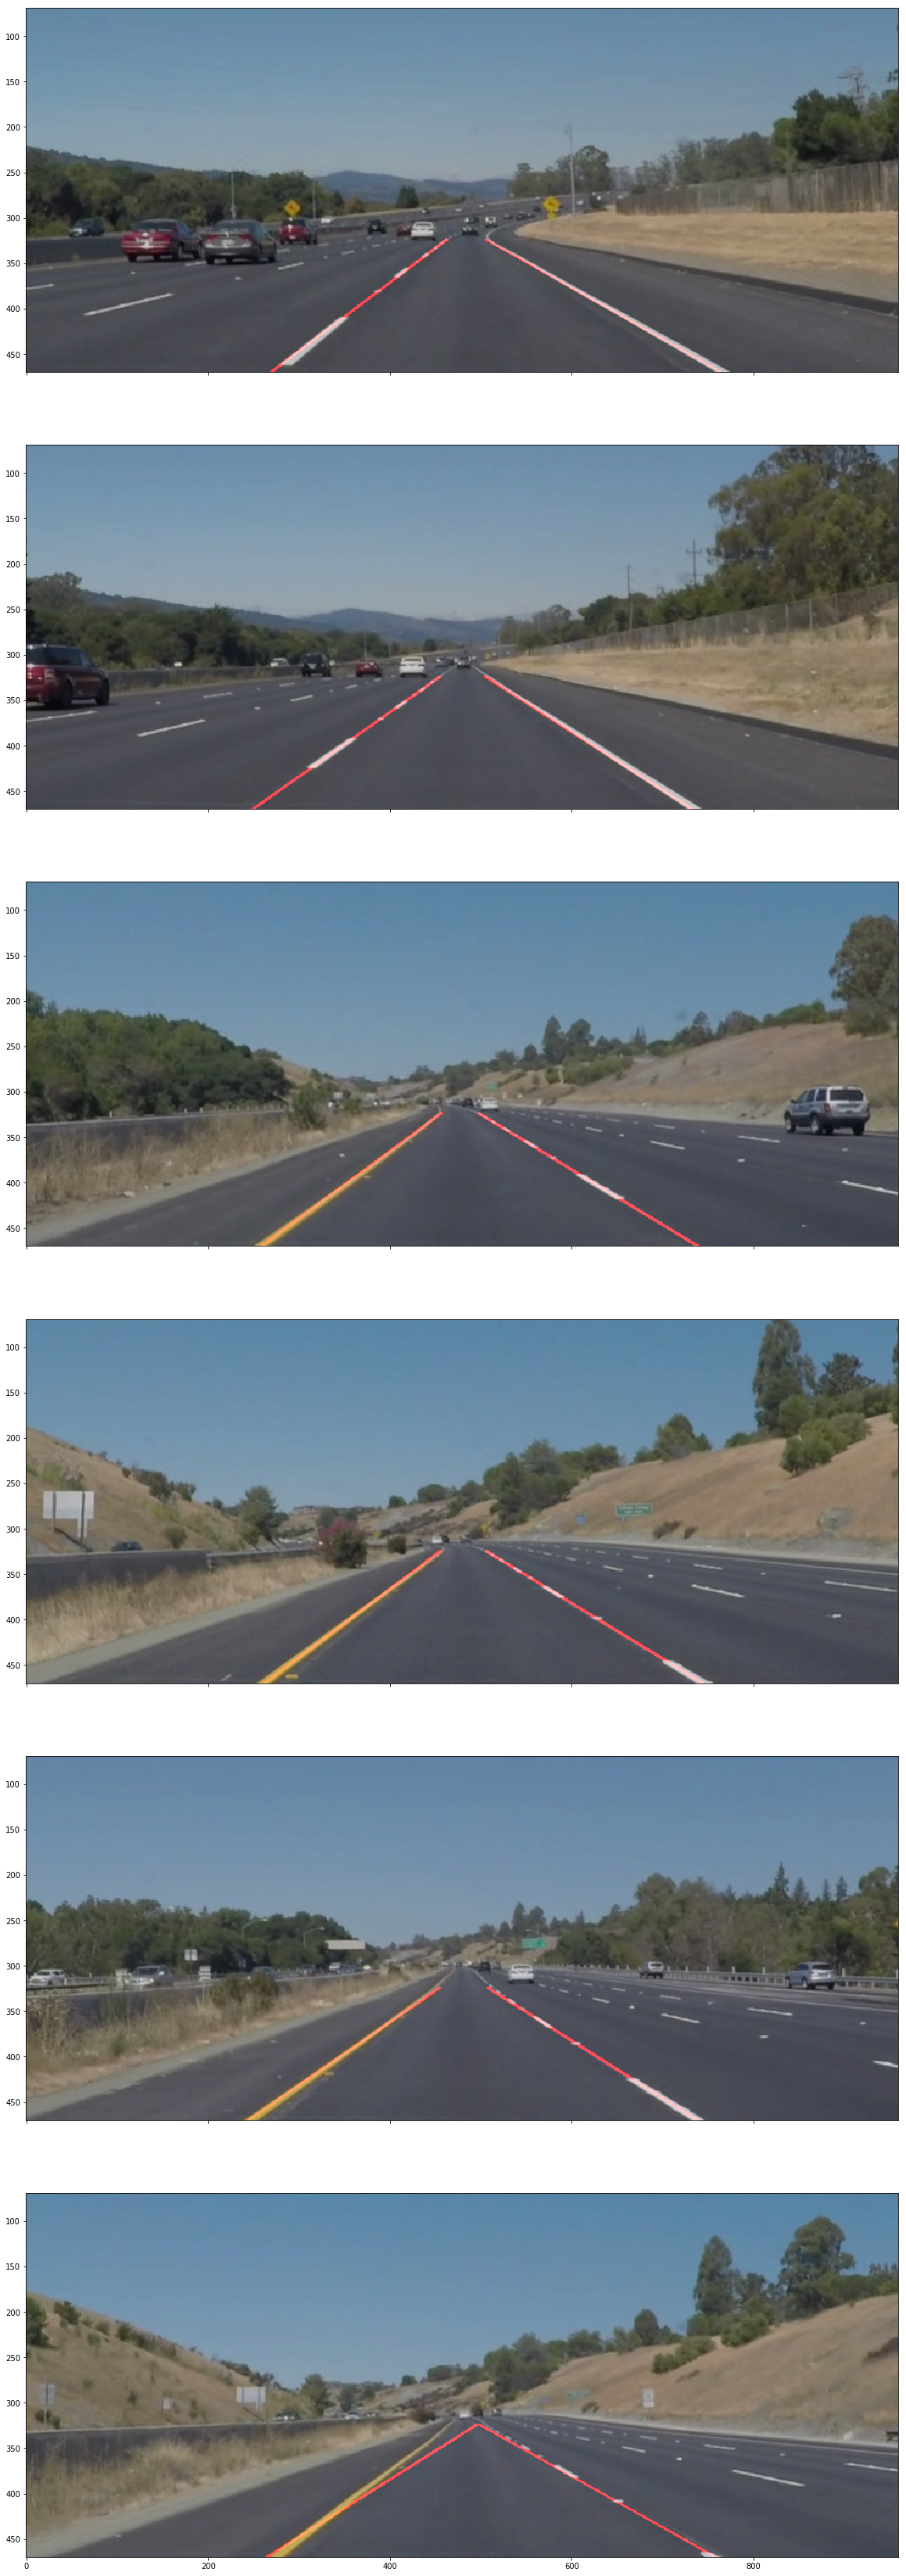

In [5]:
# Draw lane lines on the test_images and save them to the test_images_output directory.

output_image_dir = 'test_images_output'
if not os.path.exists(output_image_dir):
    os.makedirs(output_image_dir)

process_image_files(image_files, output_image_dir)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:


def process_video_file(input_dir, input_file, output_dir, log=None):
    """
    Apply the 'find_lane_lines' function to each frame in a given video file.
    Save the results to a new video file.

    Args:
        input_dir (str): Look for the input file here.
        input_file (str): Process this video file.
        output_dir (str): Write the modified video file here.

    Returns:
        str: The name fo the file containing the result of applying lane
            lines to the input video.

    To speed up the testing process you may want to try your pipeline on a
    shorter subclip of the video. To do so add

        .subclip(start_second,end_second)

    to the end of the line below, where start_second and end_second are integer
    values representing the start and end of the subclip.
    """
    # Open the video file.
    video_clip = VideoFileClip(os.path.join(input_dir, input_file))
    # For each frame in the video clip, replace the frame image with the
    # result of applying the 'find_lane_lines' function.
    # NOTE: this function expects color images!!
    lane_lines_clip = video_clip.fl_image(find_lane_lines)
    # Save the resulting, modified, video clip to a file.
    lane_lines_output = os.path.join(output_dir, input_file)
    lane_lines_clip.write_videofile(lane_lines_output, audio=False)
    # Cleanup
    video_clip.reader.close()
    video_clip.audio.reader.close_proc()
    del video_clip
    lane_lines_clip.reader.close()
    lane_lines_clip.audio.reader.close_proc()
    del lane_lines_clip
    # Return the output file name.
    return lane_lines_output


Let's try the one with the solid white lane on the right first ...

In [7]:

video_dir = 'test_videos'
output_video_dir = 'test_video_output'
if not os.path.exists(output_video_dir):
    os.makedirs(output_video_dir)

# Test lane finding for video.
white_output = process_video_file(video_dir, 'solidWhiteRight.mp4', output_video_dir)


[MoviePy] >>>> Building video test_video_output\solidWhiteRight.mp4
[MoviePy] Writing video test_video_output\solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 63.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output\solidWhiteRight.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = process_video_file(video_dir, 'solidYellowLeft.mp4', output_video_dir)


[MoviePy] >>>> Building video test_video_output\solidYellowLeft.mp4
[MoviePy] Writing video test_video_output\solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:11<00:00, 59.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output\solidYellowLeft.mp4 



In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = process_video_file(video_dir, 'challenge.mp4', output_video_dir)

[MoviePy] >>>> Building video test_video_output\challenge.mp4
[MoviePy] Writing video test_video_output\challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:08<00:00, 29.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output\challenge.mp4 



In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))